## Download the Dataset from Kaggle

In [2]:
import kagglehub

path = kagglehub.dataset_download("crawford/emnist")

print("Path to dataset files:", path)

100%|██████████| 1.24G/1.24G [00:58<00:00, 22.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/crawford/emnist/versions/3


In [3]:
import numpy as np
import pandas as pd
import os

# Listing all files under the dataset path

dataset_path = "/root/.cache/kagglehub/datasets/crawford/emnist/versions/3"

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-digits-mapping.txt
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-letters-mapping.txt
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-bymerge-test.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-bymerge-train.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-mnist-train.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-balanced-train.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-bymerge-mapping.txt
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-byclass-train.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-digits-train.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-byclass-mapping.txt
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-mnist-test.csv
/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-balanced-

## Reading the EMNIST letters dataset

In [4]:
testing_letter = pd.read_csv('/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-letters-test.csv')
training_letter = pd.read_csv('/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-letters-train.csv')
print(training_letter.shape)
print(testing_letter.shape)

(88799, 785)
(14799, 785)


In [5]:
y1 = np.array(training_letter.iloc[:,0].values)
x1 = np.array(training_letter.iloc[:,1:].values)
#testing_labels
y2 = np.array(testing_letter.iloc[:,0].values)
x2 = np.array(testing_letter.iloc[:,1:].values)
print(y1.shape)
print(x1.shape)

(88799,)
(88799, 784)


## Normalize and Reshape of the Data

In [6]:
train_images = x1 / 255.0
test_images = x2 / 255.0

train_images_number = train_images.shape[0]
train_images_height = 28
train_images_width = 28
train_images_size = train_images_height*train_images_width

train_images = train_images.reshape(train_images_number, train_images_height, train_images_width, 1)

test_images_number = test_images.shape[0]
test_images_height = 28
test_images_width = 28
test_images_size = test_images_height*test_images_width

test_images = test_images.reshape(test_images_number, test_images_height, test_images_width, 1)

Architecture:




*   4 convolutional layers with increasing filter sizes (64, 128, 256, 512)
*   Batch normalization after each convolutional layer
*   ReLU activation functions
*   2 dense layers with droput



Training Features:

*  Label smoothing for better generalization
*  Mixup data augmentation
*  L2 regularization
*  Learning rate scheduling with decay
*  Adam optimizer with customizable parameters
*  Batch processing


Data Processing:

*  Image normalization (division by 255)
*  Reshaping to 28x28x1 format
*  One-hot encoding for 47 classes
*  Batch creation with shuffling


Performance Optimization:

*  Uses JAX's J


In [7]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import numpy as np
from sklearn.preprocessing import OneHotEncoder


def load_and_preprocess_data(training_letter, testing_letter):
    y1 = np.array(training_letter.iloc[:, 0].values)
    x1 = np.array(training_letter.iloc[:, 1:].values, dtype=np.float32)
    y2 = np.array(testing_letter.iloc[:, 0].values)
    x2 = np.array(testing_letter.iloc[:, 1:].values, dtype=np.float32)

    x1 = x1 / 255.0
    x2 = x2 / 255.0

    x1 = x1.reshape(-1, 28, 28, 1)
    x2 = x2.reshape(-1, 28, 28, 1)

    encoder = OneHotEncoder(sparse_output=False, categories=[range(47)])
    y1 = encoder.fit_transform(y1.reshape(-1, 1)).astype(np.float32)
    y2 = encoder.transform(y2.reshape(-1, 1)).astype(np.float32)

    return x1, y1, x2, y2

def create_batches(x, y, batch_size):
    num_samples = len(x)
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    for start_idx in range(0, num_samples - batch_size + 1, batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        yield x[batch_indices], y[batch_indices]

def cnn(params, x, is_training=True):
    x = jax.lax.conv_general_dilated(
        x, params['conv1']['kernel'], (1, 1), 'SAME',
        dimension_numbers=('NHWC', 'HWIO', 'NHWC'))
    x = x + params['conv1']['bias'].reshape(1, 1, 1, -1)

    mean = jnp.mean(x, axis=(0, 1, 2), keepdims=True)
    var = jnp.var(x, axis=(0, 1, 2), keepdims=True)
    x = (x - mean) / jnp.sqrt(var + 1e-5)
    x = x * params['bn1']['scale'].reshape(1, 1, 1, -1) + params['bn1']['bias'].reshape(1, 1, 1, -1)

    x = jax.nn.relu(x)
    x = jax.lax.reduce_window(
        x, -jnp.inf, jax.lax.max,
        window_dimensions=(1, 2, 2, 1),
        window_strides=(1, 2, 2, 1),
        padding='SAME'
    )

    x = jax.lax.conv_general_dilated(
        x, params['conv2']['kernel'], (1, 1), 'SAME',
        dimension_numbers=('NHWC', 'HWIO', 'NHWC'))
    x = x + params['conv2']['bias'].reshape(1, 1, 1, -1)

    mean = jnp.mean(x, axis=(0, 1, 2), keepdims=True)
    var = jnp.var(x, axis=(0, 1, 2), keepdims=True)
    x = (x - mean) / jnp.sqrt(var + 1e-5)
    x = x * params['bn2']['scale'].reshape(1, 1, 1, -1) + params['bn2']['bias'].reshape(1, 1, 1, -1)

    x = jax.nn.relu(x)
    x = jax.lax.reduce_window(
        x, -jnp.inf, jax.lax.max,
        window_dimensions=(1, 2, 2, 1),
        window_strides=(1, 2, 2, 1),
        padding='SAME'
    )

    x = jax.lax.conv_general_dilated(
        x, params['conv3']['kernel'], (1, 1), 'SAME',
        dimension_numbers=('NHWC', 'HWIO', 'NHWC'))
    x = x + params['conv3']['bias'].reshape(1, 1, 1, -1)

    mean = jnp.mean(x, axis=(0, 1, 2), keepdims=True)
    var = jnp.var(x, axis=(0, 1, 2), keepdims=True)
    x = (x - mean) / jnp.sqrt(var + 1e-5)
    x = x * params['bn3']['scale'].reshape(1, 1, 1, -1) + params['bn3']['bias'].reshape(1, 1, 1, -1)

    x = jax.nn.relu(x)

    x = jax.lax.conv_general_dilated(
        x, params['conv4']['kernel'], (1, 1), 'SAME',
        dimension_numbers=('NHWC', 'HWIO', 'NHWC'))
    x = x + params['conv4']['bias'].reshape(1, 1, 1, -1)

    mean = jnp.mean(x, axis=(0, 1, 2), keepdims=True)
    var = jnp.var(x, axis=(0, 1, 2), keepdims=True)
    x = (x - mean) / jnp.sqrt(var + 1e-5)
    x = x * params['bn4']['scale'].reshape(1, 1, 1, -1) + params['bn4']['bias'].reshape(1, 1, 1, -1)

    x = jax.nn.relu(x)
    x = jnp.mean(x, axis=(1, 2))

    x = jnp.dot(x, params['dense1']['kernel']) + params['dense1']['bias']
    x = jax.nn.relu(x)
    if is_training:
        key = random.PRNGKey(0)
        x = jax.random.bernoulli(key, 0.3, x.shape) * x / 0.7  # 30% dropout

    x = jnp.dot(x, params['dense2']['kernel']) + params['dense2']['bias']
    return jax.nn.softmax(x, axis=-1)

def init_params(rng, number_of_classes):
    keys = random.split(rng, 12)
    return {
        'conv1': {
            'kernel': random.normal(keys[0], (3, 3, 1, 64)) * jnp.sqrt(2.0 / (3 * 3 * 1)),
            'bias': jnp.zeros(64)
        },
        'bn1': {
            'scale': jnp.ones(64),
            'bias': jnp.zeros(64)
        },
        'conv2': {
            'kernel': random.normal(keys[1], (3, 3, 64, 128)) * jnp.sqrt(2.0 / (3 * 3 * 64)),
            'bias': jnp.zeros(128)
        },
        'bn2': {
            'scale': jnp.ones(128),
            'bias': jnp.zeros(128)
        },
        'conv3': {
            'kernel': random.normal(keys[2], (3, 3, 128, 256)) * jnp.sqrt(2.0 / (3 * 3 * 128)),
            'bias': jnp.zeros(256)
        },
        'bn3': {
            'scale': jnp.ones(256),
            'bias': jnp.zeros(256)
        },
        'conv4': {
            'kernel': random.normal(keys[3], (3, 3, 256, 512)) * jnp.sqrt(2.0 / (3 * 3 * 256)),
            'bias': jnp.zeros(512)
        },
        'bn4': {
            'scale': jnp.ones(512),
            'bias': jnp.zeros(512)
        },
        'dense1': {
            'kernel': random.normal(keys[4], (512, 512)) * jnp.sqrt(2.0 / 512),
            'bias': jnp.zeros(512)
        },
        'dense2': {
            'kernel': random.normal(keys[5], (512, number_of_classes)) * jnp.sqrt(2.0 / 512),
            'bias': jnp.zeros(number_of_classes)
        }
    }

def smooth_labels(y, alpha=0.1):
    return y * (1 - alpha) + alpha / y.shape[1]

def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.shape[0]
    index = np.random.permutation(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    mixed_y = lam * y + (1 - lam) * y[index, :]
    return mixed_x, mixed_y

def loss_fn(params, x, y, l2_lambda=0.0001):
    logits = cnn(params, x)
    y_smooth = smooth_labels(y, alpha=0.1)
    cross_entropy_loss = -jnp.mean(jnp.sum(y_smooth * jax.nn.log_softmax(logits), axis=1))
    l2_loss = l2_lambda * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
    return cross_entropy_loss + l2_loss

def learning_rate_schedule(epoch, initial_lr=0.0003, decay_rate=0.95):
    return initial_lr * (decay_rate ** epoch)

@jit
def adam_update(params, grads, state, lr=0.0003, beta1=0.9, beta2=0.999, eps=1e-8):
    state['m'] = jax.tree_map(lambda m, g: beta1 * m + (1 - beta1) * g, state['m'], grads)
    state['v'] = jax.tree_map(lambda v, g: beta2 * v + (1 - beta2) * g**2, state['v'], grads)
    m_hat = jax.tree_map(lambda m: m / (1 - beta1 ** (state['epoch'] + 1)), state['m'])
    v_hat = jax.tree_map(lambda v: v / (1 - beta2 ** (state['epoch'] + 1)), state['v'])
    updates = jax.tree_map(lambda m, v: m / (jnp.sqrt(v) + eps), m_hat, v_hat)
    params = jax.tree_map(lambda p, u: p - lr * u, params, updates)
    return params, state

@jit
def train_step(params, state, x_batch, y_batch):
    loss_value, grads = jax.value_and_grad(loss_fn)(params, x_batch, y_batch)
    lr = learning_rate_schedule(state['epoch'])
    new_params, new_state = adam_update(params, grads, state, lr)
    return new_params, new_state, loss_value

@jit
def eval_step(params, x_batch, y_batch):
    logits = cnn(params, x_batch, is_training=False)
    loss = loss_fn(params, x_batch, y_batch)
    accuracy = jnp.mean(jnp.argmax(logits, axis=1) == jnp.argmax(y_batch, axis=1))
    return loss, accuracy

def train_model(params, state, train_batches, test_batches, epochs=100):
    for epoch in range(epochs):
        state['epoch'] = epoch
        epoch_loss = 0.0
        num_batches = 0

        for x_batch, y_batch in train_batches:
            x_batch, y_batch = mixup_data(x_batch, y_batch)
            params, state, loss = train_step(params, state, x_batch, y_batch)
            epoch_loss += loss
            num_batches += 1

        avg_train_loss = epoch_loss / num_batches

        val_loss, val_accuracy = 0.0, 0.0
        num_test_batches = 0

        for x_batch, y_batch in test_batches:
            batch_loss, batch_accuracy = eval_step(params, x_batch, y_batch)
            val_loss += batch_loss
            val_accuracy += batch_accuracy
            num_test_batches += 1

        val_loss /= num_test_batches
        val_accuracy /= num_test_batches

        print(f"Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return params, state

def main(training_letter, testing_letter, batch_size=32, epochs=20):
    x_train, y_train, x_test, y_test = load_and_preprocess_data(training_letter, testing_letter)

    key = random.PRNGKey(0)
    number_of_classes = y_train.shape[1]
    params = init_params(key, number_of_classes)

    state = {
        'm': jax.tree_map(jnp.zeros_like, params),
        'v': jax.tree_map(jnp.zeros_like, params),
        'epoch': 0
    }

    train_batches = list(create_batches(x_train, y_train, batch_size))
    test_batches = list(create_batches(x_test, y_test, batch_size))

    params, state = train_model(params, state, train_batches, test_batches, epochs)

    return params, state

if __name__ == "__main__":
    params, state = main(training_letter, testing_letter)


<ipython-input-7-0b1137116539>:235: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  'm': jax.tree_map(jnp.zeros_like, params),
<ipython-input-7-0b1137116539>:236: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  'v': jax.tree_map(jnp.zeros_like, params),
<ipython-input-7-0b1137116539>:166: DeprecationWarning: jax.tree_leaves is deprecated: use jax.tree.leaves (jax v0.4.25 or newer) or jax.tree_util.tree_leaves (any JAX version).
  l2_loss = l2_lambda * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
<ipython-input-7-0b1137116539>:174: DeprecationWarning: jax.tree_map is deprecated: use jax.tree.map (jax v0.4.25 or newer) or jax.tree_util.tree_map (any JAX version).
  state['m'] = jax.tree_map(lambda m, g: beta1 * m + (1 - beta1) * g, state['m'], grads)
<ipython-input-7-0b1137116539>:175: DeprecationWarn

Epoch 1, Train Loss: 3.6606, Validation Loss: 3.4444, Validation Accuracy: 0.7677
Epoch 2, Train Loss: 3.4737, Validation Loss: 3.3543, Validation Accuracy: 0.8370
Epoch 3, Train Loss: 3.4293, Validation Loss: 3.3282, Validation Accuracy: 0.8458
Epoch 4, Train Loss: 3.4051, Validation Loss: 3.3123, Validation Accuracy: 0.8477
Epoch 5, Train Loss: 3.3895, Validation Loss: 3.2805, Validation Accuracy: 0.8809
Epoch 6, Train Loss: 3.3683, Validation Loss: 3.2671, Validation Accuracy: 0.8849
Epoch 7, Train Loss: 3.3613, Validation Loss: 3.2575, Validation Accuracy: 0.8873
Epoch 8, Train Loss: 3.3493, Validation Loss: 3.2510, Validation Accuracy: 0.8914
Epoch 9, Train Loss: 3.3410, Validation Loss: 3.2427, Validation Accuracy: 0.8944
Epoch 10, Train Loss: 3.3425, Validation Loss: 3.2378, Validation Accuracy: 0.8957
Epoch 11, Train Loss: 3.3363, Validation Loss: 3.2344, Validation Accuracy: 0.8943
Epoch 12, Train Loss: 3.3278, Validation Loss: 3.2279, Validation Accuracy: 0.8977
Epoch 13, Tra

In [8]:
import matplotlib.pyplot as plt

In [9]:
@jit
def predict(params, x):
    """Generate predictions using the CNN model."""
    logits = cnn(params, x, is_training=False)
    return jnp.argmax(logits, axis=-1)


## Validation of the model by Predicting certain data's and visualising them

### Metrics are given

Accuracy: 0.9070

F1 Score (Macro): 0.6697

ROC AUC (Mean): 0.9874

Recall (Macro): 0.6644

Log Loss: 2.9816

Specificity (Mean): 0.9957

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(



Model Performance Metrics:
Accuracy: 0.9070
F1 Score (Macro): 0.6697
ROC AUC (Mean): 0.9874
Recall (Macro): 0.6644
Log Loss: 2.9816
Specificity (Mean): 0.9957


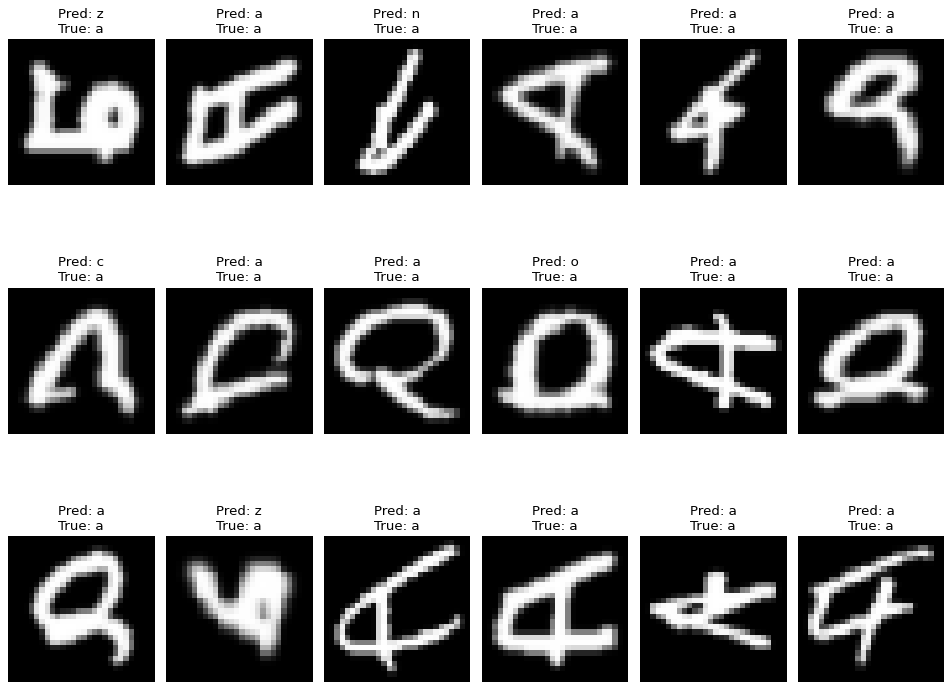

In [11]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, recall_score,
    log_loss, confusion_matrix
)

def load_test_data(testing_letter):
    """Load and preprocess test data"""
    test_y = np.array(testing_letter.iloc[:, 0].values)
    test_x = np.array(testing_letter.iloc[:, 1:].values, dtype=np.float32)
    test_x = test_x / 255.0
    test_x = test_x.reshape(-1, 28, 28, 1)
    encoder = OneHotEncoder(sparse_output=False, categories=[range(47)])
    test_y_onehot = encoder.fit_transform(test_y.reshape(-1, 1)).astype(np.float32)
    return test_x, test_y_onehot

def create_label_mapping(mapping_path):
    """Create dictionary mapping indices to letters"""
    mapp = pd.read_csv(mapping_path, sep=" ", header=None,
                      names=["index", "label"], index_col=0)
    label_dictionary = {index: chr(label) for index, label in mapp["label"].items()}
    return label_dictionary

@jax.jit
def predict(params, x):
    """Generate predictions using the CNN model"""
    logits = cnn(params, x, is_training=False)
    return jnp.argmax(logits, axis=-1)

def calculate_metrics(y_true, y_pred, y_pred_proba, label_dictionary):
    """Calculate simplified classification metrics"""
    unique_classes = np.unique(y_true)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_true, y_pred)
    specificities = []
    for i in unique_classes:
        tn = conf_matrix.sum() - (conf_matrix[i].sum() + conf_matrix[:,i].sum() - conf_matrix[i,i])
        fp = conf_matrix[:,i].sum() - conf_matrix[i,i]
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificities.append(specificity)
    mean_specificity = np.mean(specificities)
    encoder = OneHotEncoder(sparse_output=False, categories=[unique_classes])
    y_true_onehot = encoder.fit_transform(y_true.reshape(-1, 1))
    y_pred_proba_filtered = y_pred_proba[:, unique_classes]
    roc_auc_scores = []
    for i in range(len(unique_classes)):
        try:
            score = roc_auc_score(y_true_onehot[:, i], y_pred_proba_filtered[:, i])
            roc_auc_scores.append(score)
        except:
            roc_auc_scores.append(0.0)
    mean_roc_auc = np.mean(roc_auc_scores)
    logloss = log_loss(y_true_onehot, y_pred_proba_filtered)
    print("\nModel Performance Metrics:")
    print("=========================")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score (Macro): {f1:.4f}")
    print(f"ROC AUC (Mean): {mean_roc_auc:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"Log Loss: {logloss:.4f}")
    print(f"Specificity (Mean): {mean_specificity:.4f}")

    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': mean_roc_auc,
        'recall': recall,
        'log_loss': logloss,
        'specificity': mean_specificity
    }

def visualize_predictions(test_x, y_pred_test, y_true_test, label_dictionary,
                         start_idx=200, num_samples=18):
    """Visualize model predictions with true and predicted labels"""
    plt.figure(figsize=(12, 10), dpi=80)
    for i in range(num_samples):
        plt.subplot(3, 6, i + 1)
        plt.imshow(test_x[start_idx + i].reshape(28, 28), cmap=plt.cm.gray)

        predicted_label = label_dictionary[int(y_pred_test[start_idx + i])]
        true_label = label_dictionary[int(y_true_test[start_idx + i])]

        plt.title(f"Pred: {predicted_label}\nTrue: {true_label}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    test_x, test_y_onehot = load_test_data(testing_letter)
    mapping_path = "/root/.cache/kagglehub/datasets/crawford/emnist/versions/3/emnist-letters-mapping.txt"
    label_dictionary = create_label_mapping(mapping_path)
    y_pred_proba = jax.nn.softmax(cnn(params, test_x, is_training=False))
    y_pred_test = jnp.argmax(y_pred_proba, axis=-1)
    y_true_test = jnp.argmax(test_y_onehot, axis=-1)
    metrics = calculate_metrics(
        np.array(y_true_test),
        np.array(y_pred_test),
        np.array(y_pred_proba),
        label_dictionary
    )
    visualize_predictions(test_x, y_pred_test, y_true_test, label_dictionary)

if __name__ == "__main__":
    main()

## Under multiple runs we have found that our model provides better test accuracy the best till now what we have got with the same model image is displayed below. The jupyter book link and the image of it

[Jupyter NoteBook Run on local device with the below test accuracy](https://colab.research.google.com/drive/1fumHtw2FpWoWPPuf8sbkQfxDtjiP4eDN?usp=sharing)

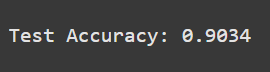